In [1]:
import pandas as pd

frame = pd.read_json('..\\Data\\ZIP_code_stats.json', lines=True)
geo_complaints = frame.fillna(0)
geo_complaints.head()

,ZIP code,BankAccount,CreditCard,CreditService,DebtCollection,Loans,Transfers,Zip,City,State,Latitude,Longitude,zipcode,NumReturns,TotalIncome,NonBank
0,37160,12.0,4.0,6.0,6.0,5.0,2.0,37160,Shelbyville,TN,35.470660,-86.45974,37160,14680,626020,0.0
1,97267,31.0,4.0,25.0,14.0,5.0,0.0,97267,Portland,OR,45.408882,-122.61476,97267,15040,961533,0.0
2,33615,76.0,19.0,69.0,53.0,16.0,2.0,33615,Tampa,FL,28.005446,-82.57776,33615,23340,1030798,0.0
3,29055,1.0,0.0,0.0,0.0,0.0,0.0,29055,Great Falls,SC,34.569908,-80.90972,29055,1690,60726,0.0
4,11236,210.0,55.0,201.0,104.0,32.0,6.0,11236,Brooklyn,NY,40.640527,-73.90362,11236,47900,2064766,0.0


In [2]:
# Remove Alaska and Hawaii so we can zoom into the continental US
continental_us_complaints = geo_complaints[~geo_complaints['State'].isin(['AK', 'HI'])]

In [3]:
# Total up the complaints into a calculated column
continental_us_complaints.loc[:, 'TotalComplaints'] = continental_us_complaints.BankAccount + \
    continental_us_complaints.CreditService + continental_us_complaints.DebtCollection + \
    continental_us_complaints.Loans + continental_us_complaints.NonBank + \
    continental_us_complaints.Transfers + continental_us_complaints.CreditCard

continental_us_complaints.loc[:, 'ComplaintsPerTaxReturn'] = continental_us_complaints.TotalComplaints \
    / continental_us_complaints.NumReturns


C:\Users\Joon\Miniconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Joon\Miniconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [4]:
##################################################################
# Research Question 1: Get outliers of complaints per tax return #
##################################################################

# Get the statistics
stats = continental_us_complaints.ComplaintsPerTaxReturn.describe()
# find all zip codes with complaints 2 standard deviations greater than the 
# mean of complaints per tax return
outliers = continental_us_complaints[continental_us_complaints['ComplaintsPerTaxReturn'] > \
                                     (stats['mean'] + (stats['std'] * 2))]

return_stats = outliers['NumReturns'].describe()
complaint_stats = outliers['TotalComplaints'].describe()

# Remove all records where the number of returns or complaints is one 
# standard deviation below the mean - the very small numbers skew 
# the overall view of the outliers
outliers = outliers[outliers['NumReturns'] > (return_stats['mean'] - \
                                              (complaint_stats['std']))]
outliers = outliers[outliers['TotalComplaints'] > (complaint_stats['mean'] - \
                                                   (complaint_stats['std']))]


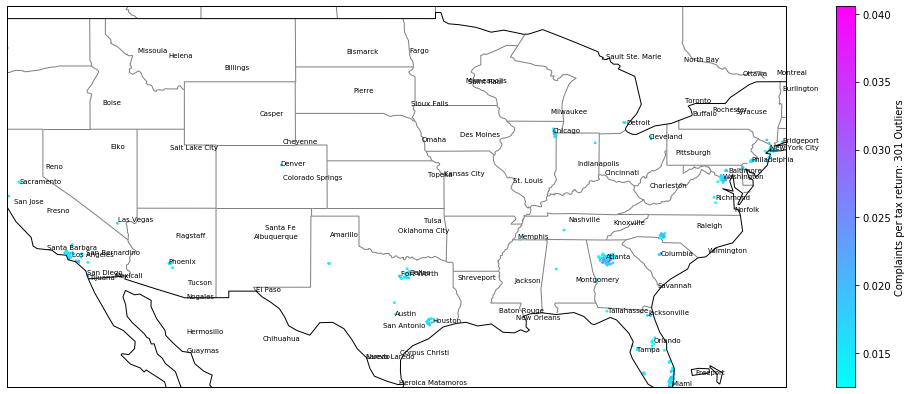

In [5]:
# Now visualize the outliers on a map of the US

import matplotlib.pyplot as plt
import cartopy.feature
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

plt.figure(figsize=(18, 7))

# Lamdba function to check if a point is inside the bounding box of
# the outliers dataset
def isInBox(item):
    return (item.attributes['LATITUDE'] >= outliers.Latitude.min()) and \
        (item.attributes['LATITUDE'] <= outliers.Latitude.max()) and \
        (item.attributes['LONGITUDE'] >= outliers.Longitude.min()) and \
        (item.attributes['LONGITUDE'] <= outliers.Longitude.max())

# Read the populated place dataset
shp_populated_places = shpreader.Reader('..\\Data\\ne_50m_populated_places')
places = shp_populated_places.records()
# Reduce the list of populated places to those that are within the 
# rectangle delineated by the outliers dataset
us_places = [p for p in places if isInBox(p)]

# Configure the axes of the plot to match the outliers dataset values
ax = plt.axes(projection=ccrs.PlateCarree())
BBox = (outliers.Longitude.min(), outliers.Longitude.max(), \
        outliers.Latitude.min(), outliers.Latitude.max())
ax.set_extent(BBox)

# Scatter plot the Long and Lat of outlying complaints, use a colormap to indicate values
plt.scatter(outliers['Longitude'].values, outliers['Latitude'].values, 3, \
            c = outliers['ComplaintsPerTaxReturn'].values, cmap = 'cool')
cbar = plt.colorbar()
cbar.set_label('Complaints per tax return: {} Outliers'.format(len(outliers)))

# Add country borders
ax.add_feature(cfeature.BORDERS)
# Add coast lines
ax.add_feature(cfeature.COASTLINE)
# Add the states
states_provinces = cfeature.NaturalEarthFeature(category='cultural', \
                                                name='admin_1_states_provinces_lines', \
                                                scale='50m', facecolor='none')
ax.add_feature(states_provinces, zorder=0, edgecolor='grey')

# Define a small font for place names
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 7}
# Draw the place names on to the map
for p in us_places:
    ax.text(p.attributes['LONGITUDE'], p.attributes['LATITUDE'], \
            p.attributes['name_en'], font)

# And finally show the plot
plt.show()

C:\Users\Joon\Miniconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Joon\Miniconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


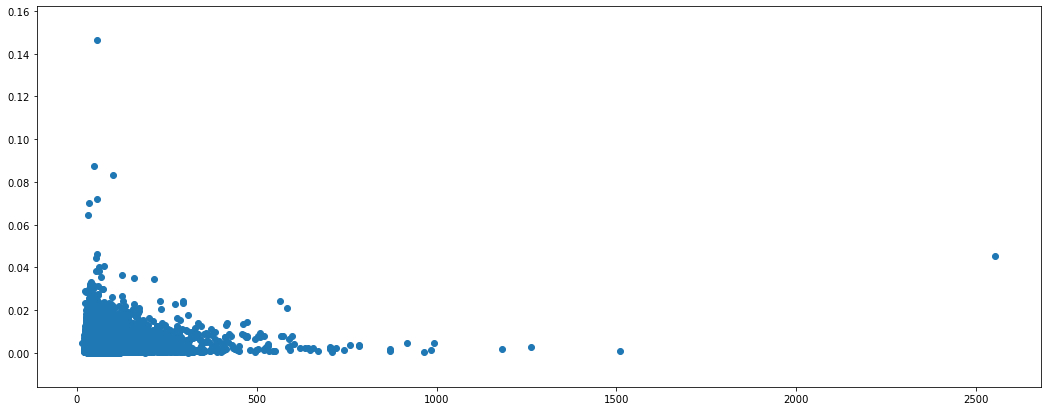

Pearsons correlation: 0.067
Spearmans correlation: 0.044


In [6]:
#############################################################################
# Research Question 2: Is there a correlation between income and complaints #
#############################################################################

# Calculate the mean income per zip code
continental_us_complaints.loc[:, 'MeanIncome'] = continental_us_complaints.TotalIncome / continental_us_complaints.NumReturns

# Now visualize mean income vs complaints per taxpayer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr

plt.figure(figsize=(18, 7))

# Scatter plot the two values to visualize any correlation
plt.scatter(continental_us_complaints['MeanIncome'].values, \
            continental_us_complaints['ComplaintsPerTaxReturn'].values)
plt.show()

# And then calculate pearson correlation coefficient
corr, _ = pearsonr(continental_us_complaints['MeanIncome'].values, \
                   continental_us_complaints['ComplaintsPerTaxReturn'].values)
print('Pearsons correlation: %.3f' % corr)

# For completeness, also calculate spearman's correlation
corr, _ = spearmanr(continental_us_complaints['MeanIncome'].values, \
                    continental_us_complaints['ComplaintsPerTaxReturn'].values)
print('Spearmans correlation: %.3f' % corr)


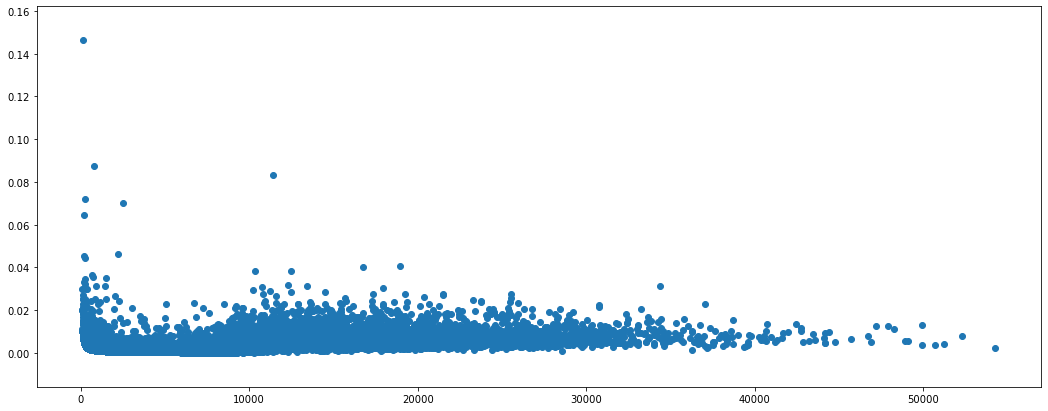

Pearsons correlation: 0.451
Spearmans correlation: 0.475


In [8]:
################################################################################
# Research Question 2b : Is there a correlation between density and complaints #
################################################################################

# Now visualize tax return total vs complaints per taxpayer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr

plt.figure(figsize=(18, 7))

# Scatter plot the two values to visualize any correlation
plt.scatter(continental_us_complaints['NumReturns'].values, \
            continental_us_complaints['ComplaintsPerTaxReturn'].values)
plt.show()

# And then calculate pearson correlation coefficient
corr, _ = pearsonr(continental_us_complaints['NumReturns'].values, \
                   continental_us_complaints['ComplaintsPerTaxReturn'].values)
print('Pearsons correlation: %.3f' % corr)

# For completeness, also calculate spearman's correlation
corr, _ = spearmanr(continental_us_complaints['NumReturns'].values, \
                    continental_us_complaints['ComplaintsPerTaxReturn'].values)
print('Spearmans correlation: %.3f' % corr)

In [15]:
####################################################################################
# Research Question 3: Determine the most complained about service per geo cluster #
####################################################################################

from sklearn.cluster import KMeans
import numpy as np

# Find all non-zero complaints
non_zero_complaints = continental_us_complaints[continental_us_complaints['TotalComplaints'] > 0]

# Combine the two lists of long and lat values into a 2-dimensional array with two columns
data = np.array(list(zip(non_zero_complaints['Longitude'].values, non_zero_complaints['Latitude'].values)))

# Create a KMeans cluster model, configured to look for 15 clusters
model = KMeans(n_clusters=15)
# Fit the model to the data, scaling it to ensure that the data is normalized
model = model.fit(data)

# Annotate each zip code with its label
continental_us_complaints.loc[:, 'Cluster'] = model.labels_.astype(float)


C:\Users\Joon\Miniconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
# Group the data frame by cluster and sum the complaints by category
groupedClusters = continental_us_complaints.groupby('Cluster').agg(
    {
         'BankAccount':sum,
         'CreditService':sum,
         'CreditCard':sum,
         'DebtCollection':sum,
         'Latitude': 'mean', 
         'Longitude': 'mean',
         'Loans':sum,
         'NonBank': sum,
         'Transfers': sum,
        
    })
# Tag each row with the name of the column with the highest value (i.e. the 
# most complained item per ZIP code)
groupedClusters.loc[:, 'MostComplaints'] = groupedClusters.idxmax(axis=1)


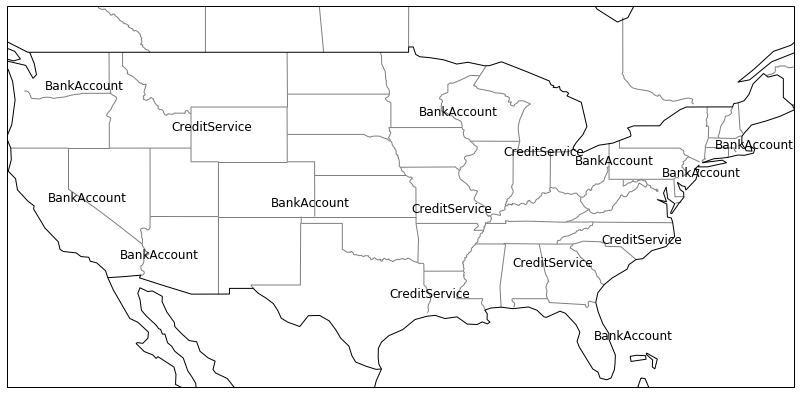

In [17]:
import matplotlib.pyplot as plt
import cartopy.feature
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Set the figure size of the plot
plt.figure(figsize=(18, 7))

# Limit the display of the map to the rectangle from the complaints dataset
ax = plt.axes(projection=ccrs.PlateCarree())
BBox = (continental_us_complaints.Longitude.min(), continental_us_complaints.Longitude.max(), \
        continental_us_complaints.Latitude.min(), continental_us_complaints.Latitude.max())
ax.set_extent(BBox)

# Add states
states_provinces = cfeature.NaturalEarthFeature(category='cultural', \
                                                name='admin_1_states_provinces_lines', \
                                                scale='50m', facecolor='none')
ax.add_feature(states_provinces, zorder=0, edgecolor='grey')
# Add country borders
ax.add_feature(cfeature.BORDERS)
# Add coastlines
ax.add_feature(cfeature.COASTLINE)

# Define a font for the print of most complained about item
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}
# Draw the most complained about item in the center of every cluster
for index, row in groupedClusters.iterrows():
    ax.text(row['Longitude'], row['Latitude'], row['MostComplaints'], font)
    
plt.show()
